# 1. Preparation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import OrderedDict
import os
from PIL import Image
import torch
from torchvision.models import detection
from torchvision.transforms import functional
from torchvision.models.detection.image_list import ImageList
from torch.jit.annotations import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
from myutils.pytorch import module_util
from models.org import rcnn
import seaborn as sns

# 2. Complexity analysis

In [3]:
def get_hierarchized_dict(component_names):
    children_dict = OrderedDict()
    for component_name in component_names:
        elements = component_name.split('.')
        if elements[0] not in children_dict and len(elements) == 1:
            children_dict[elements[0]] = component_name
            continue
        elif elements[0] not in children_dict:
            children_dict[elements[0]] = list()
        children_dict[elements[0]].append('.'.join(elements[1:]))
        
    for key in children_dict.keys():
        value = children_dict[key]
        if isinstance(value, list) and len(value) > 1:
            children_dict[key] = get_hierarchized_dict(value)
    return children_dict


def decompose(ordered_dict):
    component_list = list()
    for key, value in ordered_dict.items():
        if isinstance(value, OrderedDict):
            component_list.append((key, decompose(value)))
        elif isinstance(value, list):
            component_list.append((key, value))
        else:
            component_list.append(key)
    return component_list

def get_components(component_names):
    ordered_dict = get_hierarchized_dict(component_names)
    return decompose(ordered_dict)

In [4]:
def count_model_params(module, components, count_list):
    count = 0
    for component in components:
        child_components = None
        sub_count_list = list()
        if isinstance(component, tuple):
            component_name, child_components = component
        else:
            component_name = component

        assert hasattr(module, component_name)
        sub_module = getattr(module, component_name)
        sub_count = module_util.count_params(sub_module) if child_components is None else count_model_params(sub_module, child_components, sub_count_list)
        count_list.append(sub_count if child_components is None else sub_count_list)
        count += sub_count
    
    assert count == module_util.count_params(module)
    return count


def flatten(elements):
    sub_list = list()
    successful = True
    for element in elements:
        if isinstance(element, (list, tuple)):
            sub_list.extend(element)
            successful = False
        else:
            sub_list.append(element)
    
    return sub_list if successful else flatten(sub_list)


def get_flat_param_counts(model, components):
    param_count_list = list()
    num_params = count_model_params(model, components, param_count_list)
    flat_param_count_list = list()
    flat_component_list = list()
    for param_count in param_count_list:
        if isinstance(param_count, (list, tuple)):
            flat_param_count_list.extend(flatten(param_count))
        else:
            flat_param_count_list.append(param_count)
    return flat_param_count_list


def analyze_models(models, component_names, model_names, component_name_dict=dict()):
    sns.set()
    components = get_components(component_names)
    xs = list(range(len(component_names)))
    for model, model_name in zip(models, model_names):
        flat_param_counts = get_flat_param_counts(model, components)
        accum_param_counts = [sum(flat_param_counts[:i+1]) for i in xs]
        plt.plot(xs, accum_param_counts, label=model_name)
    
    name_list = list()
    for component_name in component_names:
        name_list.append(component_name_dict.get(component_name, component_name))
    
    plt.xticks(xs, name_list, rotation='vertical', fontsize=12)
    plt.xlabel('Main Modules', fontsize=14)
    plt.yticks(fontsize=12)
    plt.ylabel(r'Cumulative $\#$ Parameters', fontsize=14)
    plt.legend()
    plt.show()

In [5]:
rcnn_component_names = [
    'backbone.body.conv1',
    'backbone.body.bn1',
    'backbone.body.relu',
    'backbone.body.maxpool',
    'backbone.body.layer1',
    'backbone.body.layer2',
    'backbone.body.layer3',
    'backbone.body.layer4',
    'backbone.fpn',
    'rpn',
    'roi_heads'
]

rcnn_component_name_dict = {
    'backbone.body.conv1': 'Conv',
    'backbone.body.bn1': 'BatchNorm',
    'backbone.body.relu': 'ReLU',
    'backbone.body.maxpool': 'MaxPool',
    'backbone.body.layer1': 'Layer 1',
    'backbone.body.layer2': 'Layer 2',
    'backbone.body.layer3': 'Layer 3',
    'backbone.body.layer4': 'Layer 4',
    'backbone.fpn': 'FPN',
    'rpn': 'RPN',
    'roi_heads': 'RoI Heads'
}

## 2.1 Faster R-CNN

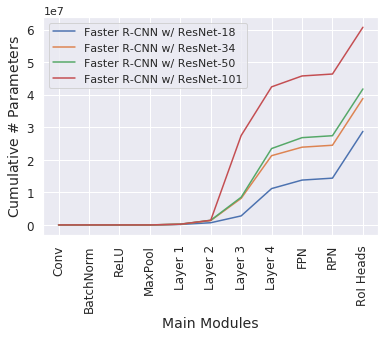

In [6]:
faster_rcnn_backbone_resnet18 = rcnn.get_model('faster_rcnn', False, backbone_config={'name': 'resnet18', 'params': {'pretrained': False, 'freeze_layers': True}})
faster_rcnn_backbone_resnet34 = rcnn.get_model('faster_rcnn', False, backbone_config={'name': 'resnet34', 'params': {'pretrained': False, 'freeze_layers': True}})
faster_rcnn_backbone_resnet50 = rcnn.get_model('faster_rcnn', False, backbone_config={'name': 'resnet50', 'params': {'pretrained': False, 'freeze_layers': True}})
faster_rcnn_backbone_resnet101 = rcnn.get_model('faster_rcnn', False, backbone_config={'name': 'resnet101', 'params': {'pretrained': False, 'freeze_layers': True}})
faster_rcnns = [faster_rcnn_backbone_resnet18, faster_rcnn_backbone_resnet34, faster_rcnn_backbone_resnet50, faster_rcnn_backbone_resnet101]
analyze_models(faster_rcnns, rcnn_component_names, ['Faster R-CNN w/ ResNet-18', 'Faster R-CNN w/ ResNet-34', 'Faster R-CNN w/ ResNet-50', 'Faster R-CNN w/ ResNet-101'], rcnn_component_name_dict)

## 2.2 Mask R-CNN

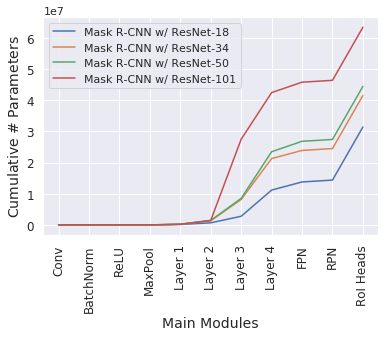

In [7]:
mask_rcnn_backbone_resnet18 = rcnn.get_model('mask_rcnn', False, backbone_config={'name': 'resnet18', 'params': {'pretrained': False, 'freeze_layers': True}})
mask_rcnn_backbone_resnet34 = rcnn.get_model('mask_rcnn', False, backbone_config={'name': 'resnet34', 'params': {'pretrained': False, 'freeze_layers': True}})
mask_rcnn_backbone_resnet50 = rcnn.get_model('mask_rcnn', False, backbone_config={'name': 'resnet50', 'params': {'pretrained': False, 'freeze_layers': True}})
mask_rcnn_backbone_resnet101 = rcnn.get_model('mask_rcnn', False, backbone_config={'name': 'resnet101', 'params': {'pretrained': False, 'freeze_layers': True}})
mask_rcnns = [mask_rcnn_backbone_resnet18, mask_rcnn_backbone_resnet34, mask_rcnn_backbone_resnet50, mask_rcnn_backbone_resnet101]
analyze_models(mask_rcnns, rcnn_component_names, ['Mask R-CNN w/ ResNet-18', 'Mask R-CNN w/ ResNet-34', 'Mask R-CNN w/ ResNet-50', 'Mask R-CNN w/ ResNet-101'], rcnn_component_name_dict)

## 2.3 Keypoint R-CNN

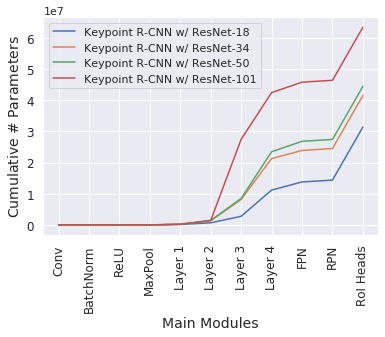

In [8]:
keypoint_rcnn_backbone_resnet18 = rcnn.get_model('keypoint_rcnn', False, num_classes=2, backbone_config={'name': 'resnet18', 'params': {'pretrained': False, 'freeze_layers': True}})
keypoint_rcnn_backbone_resnet34 = rcnn.get_model('keypoint_rcnn', False, num_classes=2, backbone_config={'name': 'resnet34', 'params': {'pretrained': False, 'freeze_layers': True}})
keypoint_rcnn_backbone_resnet50 = rcnn.get_model('keypoint_rcnn', False, num_classes=2, backbone_config={'name': 'resnet50', 'params': {'pretrained': False, 'freeze_layers': True}})
keypoint_rcnn_backbone_resnet101 = rcnn.get_model('keypoint_rcnn', False, num_classes=2, backbone_config={'name': 'resnet101', 'params': {'pretrained': False, 'freeze_layers': True}})
keypoint_rcnns = [keypoint_rcnn_backbone_resnet18, keypoint_rcnn_backbone_resnet34, keypoint_rcnn_backbone_resnet50, keypoint_rcnn_backbone_resnet101]
analyze_models(mask_rcnns, rcnn_component_names, ['Keypoint R-CNN w/ ResNet-18', 'Keypoint R-CNN w/ ResNet-34', 'Keypoint R-CNN w/ ResNet-50', 'Keypoint R-CNN w/ ResNet-101'], rcnn_component_name_dict)

# 3. Tensor size analysis

In [9]:
def load_img(file_path, shows_img=True):
    img = Image.open(os.path.expanduser(file_path)).convert('RGB')
    plt.axis('off')
    if shows_img:
        plt.imshow(img)
    return functional.to_tensor(img)


def custom_forward(rcnn, hooked_component_names, images, targets=None):
    # type: (List[Tensor], Optional[List[Dict[str, Tensor]]])
    tensor_list = list()
    def forward_hook(self, input, output):
        tensor_list.append(output)
    
    handle_list = list()
    for hooked_component_name in hooked_component_names:
        module = module_util.get_module(rcnn, hooked_component_name)
        handle_list.append(module.register_forward_hook(forward_hook))
    
    rcnn.eval()
    
    if rcnn.training and targets is None:
        raise ValueError("In training mode, targets should be passed")
    original_image_sizes = torch.jit.annotate(List[Tuple[int, int]], [])
    for img in images:
        val = img.shape[-2:]
        assert len(val) == 2
        original_image_sizes.append((val[0], val[1]))

    images, targets = rcnn.transform(images, targets)
    tensor_list.append(images)
    features = rcnn.backbone(images.tensors)
    
    if isinstance(features, torch.Tensor):
        features = OrderedDict([('0', features)])
        
    proposals, proposal_losses = rcnn.rpn(images, features, targets)
    detections, detector_losses = rcnn.roi_heads(features, proposals, images.image_sizes, targets)
    detections = rcnn.transform.postprocess(detections, images.image_sizes, original_image_sizes)
    tensor_list.append(detections)

    losses = {}
    losses.update(detector_losses)
    losses.update(proposal_losses)
    
    for handle in handle_list:
        handle.remove()

    if torch.jit.is_scripting():
        if not rcnn._has_warned:
            warnings.warn("RCNN always returns a (Losses, Detections) tuple in scripting")
            rcnn._has_warned = True
        return (losses, detections), tensor_list
    return detections, tensor_list


def get_tensor_size(x):
    if isinstance(x, ImageList):
        tensor_size = 1
        for z in x.image_sizes[0]:
            tensor_size *= z
        return tensor_size
    elif isinstance(x, (tuple, list)):
        return sum([get_tensor_size(z) for z in x])
    elif isinstance(x, dict):
        return sum([get_tensor_size(z) for z in x.values()])
    elif isinstance(x, torch.Tensor):
        tensor_size = 1
        for z in x.shape:
            tensor_size *= z
        return tensor_size
    
    print('Unexpected type: {}'.format(type(x)))
    raise ValueError
    


def analyze_tensor_sizes(rcnn, hooked_component_names, rcnn_component_name_dict, images, model_name):
    _, output_tensors = custom_forward(rcnn, hooked_component_names, imgs)
    name_list = ['Input']
    for component_name in hooked_component_names:
        name_list.append(rcnn_component_name_dict.get(component_name, component_name))
    
    name_list.append('Postprocess')
    output_size_list = list()
    accumulated_set = {'Layer 2', 'Layer 3', 'Layer 4'}
    for i, (name, output_tensor) in enumerate(zip(name_list, output_tensors)):
        output_size_list.append(get_tensor_size(output_tensor))
        if name in accumulated_set:
            output_size_list[-1] += output_size_list[-2]
            accumulated_set.remove(name)
            
    assert len(accumulated_set) == 0, 'A set of no properly processed {}'.format(accumulated_set)
    tensor_sizes = np.array(output_size_list)
    
    xs = list(range(len(name_list[:-1])))
    plt.plot(xs, [1 for _ in xs], label='Input Tensor')
    plt.plot(xs, tensor_sizes[:-1] / tensor_sizes[0], label=model_name)
    plt.xticks(xs, name_list, rotation='vertical', fontsize=12)
    plt.xlabel('Splitting Points', fontsize=14)
    plt.yticks(fontsize=12)
    plt.ylabel(r'Normalized Tensor Size', fontsize=14)
    plt.legend()
    plt.show()

In [10]:
imgs = [torch.rand(3, 800, 800)]

## 3.1 Faster R-CNN with ResNet-50

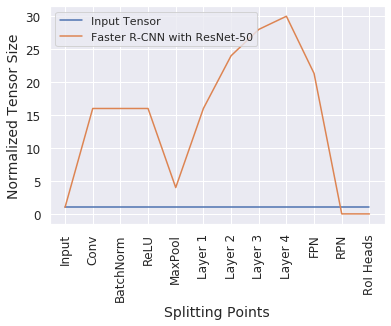

In [11]:
analyze_tensor_sizes(faster_rcnn_backbone_resnet50, rcnn_component_names, rcnn_component_name_dict, imgs, 'Faster R-CNN with ResNet-50')

## 3.2 Mask R-CNN with ResNet-50

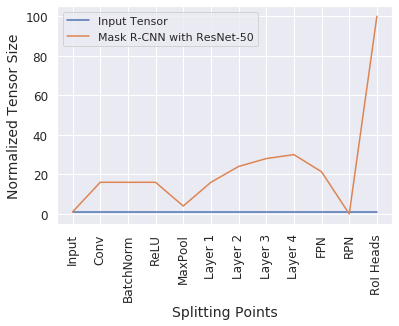

In [12]:
analyze_tensor_sizes(mask_rcnn_backbone_resnet50, rcnn_component_names, rcnn_component_name_dict, imgs, 'Mask R-CNN with ResNet-50')

## 3.3 Keypoint R-CNN with ResNet-50

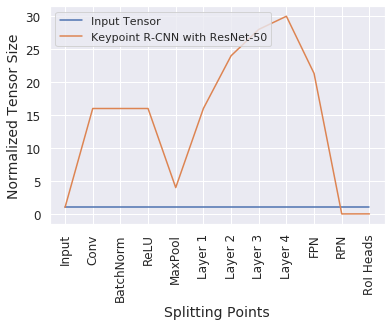

In [13]:
analyze_tensor_sizes(keypoint_rcnn_backbone_resnet50, rcnn_component_names, rcnn_component_name_dict, imgs, 'Keypoint R-CNN with ResNet-50')